Use the same data and source code but add two more layers to encoder path and their corresponding two layers to decoder path, run the new model and report your findings. In your report specify which 4 layers (2 layers in encoder path and 2 layers in decoder path) have you added and explain why you added those (their function). 
Examples of layers that can be added Conv2D, Batchnorm, Conv2DTranspose etc. 



Explanation on adding more layers:
There are pros and cons to adding additional layers. The only way to know what will work best is to try it out. By adding more layers, I did not see a significant improvement in my output. In theory the more convolutional layer a model contains the slower it will be, but by adding more kernels per layer can help mitigate the slower process and using GPU to speed things up. After adding more layers one problem I encountered was my output for decoder did not match my input for encoder. One of the ways to fix this issue is by adjusting the strides variable. The stride argument was set to 2 but after playing around with random numbers for each layer in the decoder cell, I was able to match the input and output to 28 X 28 X 1. But by adding the additional layer and changing the stride value my output did not come out that great. The output was not that great which did not make too much of sense. Stride is often used for down sample the output channel. To fix this problem after adding additional layer I opted to using the cropping method to make sure my input and output matched so I could run train and compile my data. 



Importing the requires libraires

In [42]:
import keras
import tensorflow as tf
from keras.layers import Conv2D, Conv2DTranspose, Input, Flatten, Dense, Lambda, Reshape
from keras.layers import BatchNormalization
from keras.models import Model
from keras.datasets import mnist
from keras.losses import binary_crossentropy
from keras import backend as K
import numpy as np
import matplotlib.pyplot as plt

MNIST dataset will be utilized for training the autoencoder. The dataset consistes of 28 X 28 pixel images. The goal is for our autoencoder to learn the distribution of the written digits across 2D latent space.

In [43]:
#load MNIST dataset
(input_train_1, target_train_1), (input_test_1, target_test_1) = mnist.load_data()


Looking at the data

In [44]:
print(input_train_1.shape)
print(input_test_1.shape)
print(target_train_1.shape)
print(target_test_1.shape)

(60000, 28, 28)
(10000, 28, 28)
(60000,)
(10000,)


Reducing the data size 

In [45]:
input_train=input_train_1[0:10000]
target_train=target_train_1[0:10000]
input_test=input_test_1[0:1000]
target_test=target_test_1[0:1000]

Looking at the first 10 images 

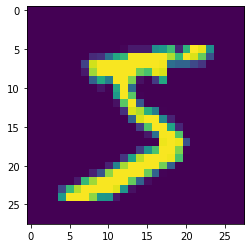

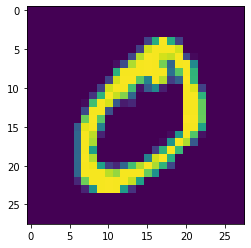

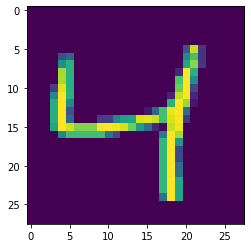

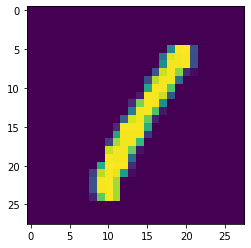

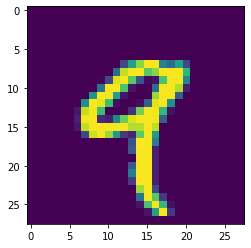

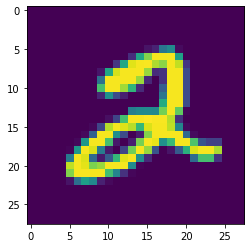

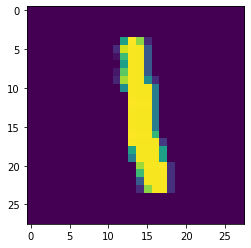

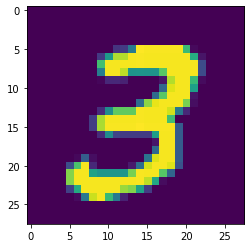

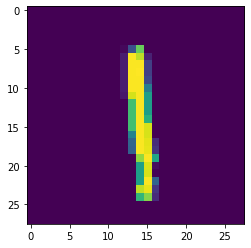

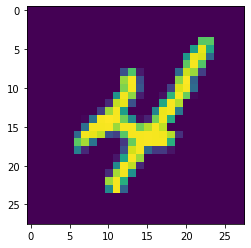

In [46]:
for i in range(10):
  pr_img = input_train[i]
  pr_img = np.array(pr_img, dtype='float')
  pixels = pr_img.reshape(28,28)
  plt.imshow(pixels)
  plt.show()

Looking at the reducded dataset size 

In [47]:
print(input_train.shape)
print(input_test.shape)
print(target_train.shape)
print(target_test.shape)

(10000, 28, 28)
(1000, 28, 28)
(10000,)
(1000,)


In [35]:
print(input_train.shape[1])

28


In [36]:
print(input_train.shape[2])

28


Model configuration: setting configuration parameters for data and model.
The width is obtained from the training data. The height and width are 28, and the batch size is set to 128 samples per batch. 
verbosity is set to true (be means of 1). This allows the output to display everything on the screen. 


In [48]:
#configuration of data and model 
img_width, img_height = input_train.shape[1], input_train.shape[2]
batch_size = 128
no_epochs = 100
validation_split = 0.2
verbosity = 1
latent_dim = 2
num_channels = 1

In [10]:
print(input_train.shape[0])

10000


The data is reshaped to refelct the traning or test data. (X, 28,28,1), where X is the number of smaples in trainning or test

In [49]:
#reshape data
input_train = input_train.reshape(input_train.shape[0], img_height, img_width, num_channels)
input_test = input_test.reshape(input_test.shape[0], img_height, img_width, num_channels)
input_shape = (img_height, img_width, num_channels)

#parse numbers as floats
input_train = input_train.astype('float32')
input_test = input_test.astype('float32')


#normalize data
input_train = input_train / 255
input_test = input_test / 255

Encoder seup

In [50]:
# Encoder Definition
i       = Input(shape=input_shape, name='encoder_input')
# layer 1
cx      = Conv2D(filters=8, kernel_size=3, strides=2, padding='same', activation='relu')(i)
cx      = BatchNormalization()(cx)
#layer 2
cx      = Conv2D(filters=16, kernel_size=3, strides=2, padding='same', activation='relu')(cx)
cx      = BatchNormalization()(cx)
#layer 3
cx      = Conv2D(filters=16, kernel_size=3, strides=2, padding='same', activation='relu')(cx)
cx      = BatchNormalization()(cx)
#layer 4
cx      = Conv2D(filters=16, kernel_size=3, strides=2, padding='same', activation='relu')(cx)
cx      = BatchNormalization()(cx)



x       = Flatten()(cx)
x       = Dense(20, activation='relu')(x)
x       = BatchNormalization()(x)
mu      = Dense(latent_dim, name='latent_mu')(x)
sigma   = Dense(latent_dim, name='latent_sigma')(x)

We can see that first layer is the input layer, which takes in the input_shape = (282, 28,1) and name = 'enocder_input'

Then the 2D convolutional layer, or Connv2D. This will learn 8 filters by deploying 3 x 3 kernel. Uses padding 'same' and ReLU activation.

Batch Normaliztion is applied. This ensures that the outputs of the Conv2D layer that are input to the next Conv2D layer have a steady mean and variance. 

A Conv2D layer is added again. It learns 16 filters and the rest is equal to the first Conv2D layer 

Bath is normalized again

The Flatten layer is added, it purpose it flatten the multi-dimensional data from the convolutional layer into one dimensional shape. 

The Dense layer is added with 20 output neurons. 

BatchNormaliztino is added again 

The final two layers mu and sigma. The first output means value u of the encoded input and the second one outputs the stddevs. 

Will need to retrieve the shape of the final Conv2D output

In [51]:
#get shape for Conv2D
conv_shape = K.int_shape(cx)


In [52]:
#Define sampling with reparametirzaton 
def sample_z(args):
  mu, sigma = args
  batch     = K.shape(mu)[0]
  dim       = K.int_shape(mu)[1]
  eps       = K.random_normal(shape=(batch, dim))
  return mu + K.exp(sigma / 2) * eps

This is to enusre correct gradients are computed during the backwards pass based on our values for mu and sigma

In [53]:
z       = Lambda(sample_z, output_shape=(latent_dim, ), name='z')([mu, sigma])

In [40]:
print(z.shape)

(None, 2)


Encoder instantiation, this will take inputs through the input layer i and outputting values genereated by mu, sigma and z layers 

In [54]:
#instantiate encoder
encoder = Model(i, [mu, sigma, z], name='encoder')
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
conv2d_4 (Conv2D)               (None, 14, 14, 8)    80          encoder_input[0][0]              
__________________________________________________________________________________________________
batch_normalization_10 (BatchNo (None, 14, 14, 8)    32          conv2d_4[0][0]                   
__________________________________________________________________________________________________
conv2d_5 (Conv2D)               (None, 7, 7, 16)     1168        batch_normalization_10[0][0]     
____________________________________________________________________________________________

Creating decoder

Decoder begins with an input layer the decoder_layer and taks input witht the shape of (latent_dim).
Conv2DTranspose layer is to unsample the point in latent space 
adding BatchNormaliztion  and conv2dTranspose. Still have 8 filters with shape of (28,28,8)
Final step Conv2DTranspose layer which does nothing to the width and height of the data, but makes sure that the numbber of filters learns equals num_channels 

In [55]:
# Decoder Definition
d_i   = Input(shape=(latent_dim, ), name='decoder_input')

x     = Dense(conv_shape[1] * conv_shape[2] * conv_shape[3], activation='relu')(d_i)

x     = BatchNormalization()(x)

x     = Reshape((conv_shape[1], conv_shape[2], conv_shape[3]))(x)
#layer 1
cx    = Conv2DTranspose(filters=64, kernel_size=3, strides=2, padding='same', activation='relu')(x)
cx    = BatchNormalization()(cx)
#layer 2
cx    = Conv2DTranspose(filters=32, kernel_size=3, strides=2, padding='same', activation='relu')(cx)
cx    = BatchNormalization()(cx)
cx    = tf.keras.layers.Cropping2D(cropping=((0,1),(0,1)))(cx) 
#layer 3
cx    = Conv2DTranspose(filters=16, kernel_size=3, strides=2, padding='same',  activation='relu')(cx)
cx    = BatchNormalization()(cx)
#layer 4
cx    = Conv2DTranspose(filters=8, kernel_size=3, strides=2, padding='same',  activation='relu')(cx)
cx    = BatchNormalization()(cx)

o     = Conv2DTranspose(filters=num_channels, kernel_size=3, activation='sigmoid', padding='same', name='decoder_output')(cx)

In [56]:
# Instantiate decoder
decoder = Model(d_i, o, name='decoder')
decoder.summary()

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
decoder_input (InputLayer)   [(None, 2)]               0         
_________________________________________________________________
dense_3 (Dense)              (None, 64)                192       
_________________________________________________________________
batch_normalization_15 (Batc (None, 64)                256       
_________________________________________________________________
reshape_1 (Reshape)          (None, 2, 2, 16)          0         
_________________________________________________________________
conv2d_transpose_4 (Conv2DTr (None, 4, 4, 64)          9280      
_________________________________________________________________
batch_normalization_16 (Batc (None, 4, 4, 64)          256       
_________________________________________________________________
conv2d_transpose_5 (Conv2DTr (None, 8, 8, 32)          1846

In [57]:
# Instantiate VAE
vae_outputs = decoder(encoder(i)[2])
vae         = Model(i, vae_outputs, name='vae')
vae.summary()

Model: "vae"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   [(None, 28, 28, 1)]       0         
_________________________________________________________________
encoder (Functional)         [(None, 2), (None, 2), (N 7576      
_________________________________________________________________
decoder (Functional)         (None, 28, 28, 1)         34529     
Total params: 42,105
Trainable params: 41,585
Non-trainable params: 520
_________________________________________________________________


In [25]:
tf.config.run_functions_eagerly(True)
# Compile VAE
vae.compile(optimizer='adam', loss='binary_crossentropy')

# Train autoencoder
vae.fit(input_train, input_train, epochs =no_epochs, batch_size = batch_size, validation_split = validation_split)

Epoch 1/100
 1/63 [..............................] - ETA: 0s - loss: 0.2072

/usr/local/lib/python3.6/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3350: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  "Even though the tf.config.experimental_run_functions_eagerly "


63/63 [==============================] - 3s 48ms/step - loss: 0.2129 - val_loss: 0.2169
Epoch 2/100
63/63 [==============================] - 3s 48ms/step - loss: 0.2076 - val_loss: 0.2139
Epoch 3/100
63/63 [==============================] - 3s 47ms/step - loss: 0.2043 - val_loss: 0.2086
Epoch 4/100
63/63 [==============================] - 3s 47ms/step - loss: 0.2028 - val_loss: 0.2072
Epoch 5/100
63/63 [==============================] - 3s 47ms/step - loss: 0.2005 - val_loss: 0.2039
Epoch 6/100
63/63 [==============================] - 3s 46ms/step - loss: 0.1990 - val_loss: 0.2015
Epoch 7/100
63/63 [==============================] - 3s 48ms/step - loss: 0.1976 - val_loss: 0.2051
Epoch 8/100
63/63 [==============================] - 3s 49ms/step - loss: 0.1970 - val_loss: 0.2019
Epoch 9/100
63/63 [==============================] - 3s 48ms/step - loss: 0.1955 - val_loss: 0.1989
Epoch 10/100
63/63 [==============================] - 3s 47ms/step - loss: 0.1944 - val_loss: 0.1997
Epoch 11/10

In [26]:

# Results visualization
# Credits for original visualization code: https://keras.io/examples/variational_autoencoder_deconv/


def viz_latent_space(encoder, data):
  input_data, target_data = data
  mu, _, _ = encoder.predict(input_data)
  plt.figure(figsize=(8, 10))
  plt.scatter(mu[:, 0], mu[:, 1], c=target_data)
  plt.xlabel('z - dim 1')
  plt.ylabel('z - dim 2')
  plt.colorbar()
  plt.show()

In [27]:
def viz_decoded(encoder, decoder, data):
  num_samples = 15
  figure = np.zeros((img_width * num_samples, img_height * num_samples, num_channels))
  grid_x = np.linspace(-4, 4, num_samples)
  grid_y = np.linspace(-4, 4, num_samples)[::-1]
  for i, yi in enumerate(grid_y):
      for j, xi in enumerate(grid_x):
          z_sample = np.array([[xi, yi]])
          x_decoded = decoder.predict(z_sample)
          digit = x_decoded[0].reshape(img_width, img_height, num_channels)
          figure[i * img_width: (i + 1) * img_width,
                  j * img_height: (j + 1) * img_height] = digit
  plt.figure(figsize=(10, 10))
  start_range = img_width // 2
  end_range = num_samples * img_width + start_range + 1
  pixel_range = np.arange(start_range, end_range, img_width)
  sample_range_x = np.round(grid_x, 1)
  sample_range_y = np.round(grid_y, 1)
  plt.xticks(pixel_range, sample_range_x)
  plt.yticks(pixel_range, sample_range_y)
  plt.xlabel('z - dim 1')
  plt.ylabel('z - dim 2')
  # matplotlib.pyplot.imshow() needs a 2D array, or a 3D array with the third dimension being of shape 3 or 4!
  # So reshape if necessary
  fig_shape = np.shape(figure)
  if fig_shape[2] == 1:
    figure = figure.reshape((fig_shape[0], fig_shape[1]))
  # Show image
  plt.imshow(figure)
  plt.show()

/usr/local/lib/python3.6/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3350: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  "Even though the tf.config.experimental_run_functions_eagerly "


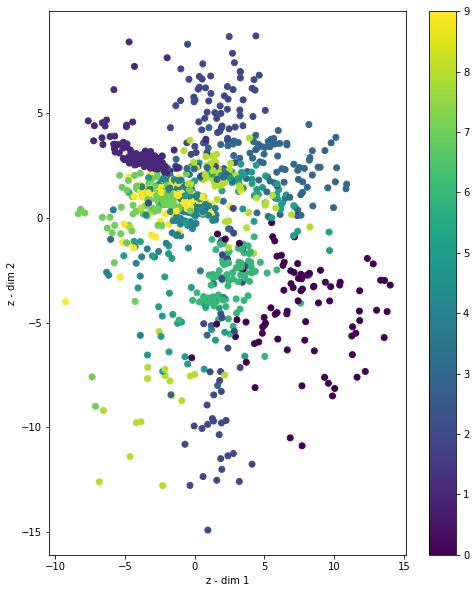

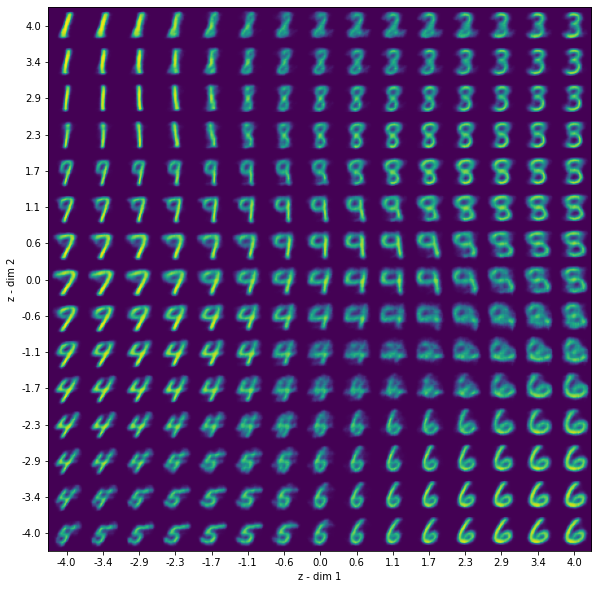

In [28]:

# Plot results
data = (input_test, target_test)
viz_latent_space(encoder, data)
viz_decoded(encoder, decoder, data)